# Notebook per regressione lineare

Di seguito:
- verrà implementato l'algoritmo di regressione logistica

## Scaricamento dei dati

In [ ]:
# File per scaricare i dati per fare analisi di machine learning

import requests
import zipfile
import io
import os

# List of URLs to your zipped files on AWS
urls = [
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip"]

# Directory to save the extracted files
output_dir = "dataset"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    try:
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        # Read the zip file from the response content
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extract all contents to the specified output directory
            zip_ref.extractall(output_dir)
            print(f"Extracted files from {url} to {output_dir}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except zipfile.BadZipFile:
        print(f"Error: The downloaded file from {url} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

print("Download and extraction complete.")

# Now you can access your CSV files in the 'downloaded_data' directory
# For example, to list the files in the directory:
import glob
csv_files = glob.glob(os.path.join(output_dir, "*.csv"))
print("CSV files found:", csv_files)

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to dataset
Download and extraction complete.
CSV files found: ['dataset/X_train.csv', 'dataset/y_train.csv']


## Estrazione dei dati

In [ ]:
import pandas as pd

def load_data(x_path, y_path):
  """
  Loads X.csv and the second column of y.csv into a single pandas DataFrame.

  Args:
    x_path (str): The path to the X.csv file.
    y_path (str): The path to the y.csv file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from X.csv
                      and the second column of y.csv.
  """
  x = pd.read_csv(x_path)
  y = pd.read_csv(y_path)

  # Assuming y has at least 2 columns and the second column is at index 1
  if y.shape[1] > 1:
    combined_data = x.copy()
    combined_data['y_target'] = y.iloc[:, 1]
    return combined_data
  else:
    print("Error: y.csv does not have a second column.")
    return x

# Example usage:
# Assuming your files are in the 'dataset' directory as per the preceding code
x_path = 'dataset/X_train.csv'
y_path = 'dataset/y_train.csv'

data = load_data(x_path, y_path)

# You can now work with the 'data' DataFrame
print(data.head())


   id  trq_measured       oat       mgt         pa       ias         np  \
0   0        54.100   2.00000  544.5000   212.1408  74.56250   89.18000   
1   1        49.625  24.22231  578.4844  1625.6400  30.35596   99.55273   
2   2        52.000   7.00000  566.1000  1912.9250  65.62500  100.14000   
3   3        62.400   7.25000  560.1000   277.0632  54.81250   90.64000   
4   4        62.900  23.25000  593.7000    53.6448  73.43750   99.91000   

         ng  y_target  
0   99.6400         1  
1   91.3866         0  
2   90.9600         1  
3  100.2800         0  
4   92.1700         0  


## Creazione training-set testing-set

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

print("Dimensione data_train:", data_train.shape)
print("Dimensione data_test:", data_test.shape)

Dimensione data_train: (594100, 9)
Dimensione data_test: (148525, 9)


In [ ]:
# Useful package
import requests
import zipfile
import io
import os

import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns









def transform_with_custom_root(df, column_name, root_degree):
  """
  Applies a custom root transformation (1/root_degree power) to a column.
  Handles positive, negative, and zero values appropriately based on the root degree.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.
    root_degree (float): The degree of the root (e.g., 2 for square root, 3 for cube root).

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  new_column_name = f'{column_name}_root_{root_degree:.2f}_transformed'

  if root_degree == 0:
      raise ValueError("Root degree cannot be zero.")
  elif root_degree % 2 == 0:  # Even root
      # For even roots, we can only take the root of non-negative numbers
      if (df[column_name] < 0).any():
          print(f"Warning: Column '{column_name}' contains negative values. Cannot apply even root directly.")
          # You might choose to handle this by taking the root of the absolute value,
          # or setting negative values to NaN, depending on your data context.
          # Here, we'll take the root of the absolute value for demonstration.
          df[new_column_name] = np.power(np.abs(df[column_name]), 1/root_degree)
      else:
          df[new_column_name] = np.power(df[column_name], 1/root_degree)
  else:  # Odd root
      # Odd roots can handle positive, negative, and zero values
      df[new_column_name] = np.sign(df[column_name]) * np.power(np.abs(df[column_name]), 1/root_degree)

  return df

# Example usage with a custom root (e.g., 1.5)
# custom_root_degree = 2.35
# data_train = transform_with_custom_root(data_train.copy(), 'power_avail', custom_root_degree)


def create_binned_qualitative_variable(df, column_name, num_bins, strategy='quantile'):
  """
  Creates a qualitative (categorical) variable by binning a numerical column.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the numerical column to bin.
    num_bins (int): The desired number of bins.
    strategy (str): The strategy to use for binning. 'quantile' uses quantiles
                    to ensure bins have approximately equal numbers of observations.
                    'uniform' creates bins with equal widths. Default is 'quantile'.

  Returns:
    pd.DataFrame: The DataFrame with a new qualitative column.
                  The new column name will be f'{column_name}_binned_{num_bins}_{strategy}'.
  """
  if column_name not in df.columns:
    raise ValueError(f"La colonna '{column_name}' non è presente nel DataFrame.")
  if num_bins <= 1:
      raise ValueError("Il numero di bins deve essere maggiore di 1.")

  new_column_name = f'{column_name}_binned_{num_bins}_{strategy}'

  if strategy == 'quantile':
    # Use qcut to create bins based on quantiles (approximately equal number of observations)
    # `duplicates='drop'` handles cases where quantile boundaries are not unique,
    # which can happen with skewed or discrete data.
    df[new_column_name] = pd.qcut(df[column_name], q=num_bins, labels=False, duplicates='drop')
  elif strategy == 'uniform':
    # Use cut to create bins of equal width
    df[new_column_name] = pd.cut(df[column_name], bins=num_bins, labels=False, include_lowest=True)
  else:
    raise ValueError(f"Strategia di binning non valida: '{strategy}'. Scegliere tra 'quantile' o 'uniform'.")

  # Convert the binned column to object/category type if needed, or keep as int for simplicity
  # Here we keep it as int representing the bin number

  return df

# Example usage for 'indicated_air_speed':
# num_bins_indicated_air_speed = 5 # Define the number of bins
# binning_strategy = 'quantile' # Or 'uniform'

#data_train = create_binned_qualitative_variable(
#    data_train.copy(),
#    'indicated_air_speed',
#    num_bins_indicated_air_speed,
#    strategy=binning_strategy
#)




## PCA per indicated_air_speed e compressor_speed
# Select the columns for PCA
# features_for_pca = data_train[['compressor_speed', 'net_power']]
# Initialize PCA with 1 component (to combine the two variables)
# pca = PCA(n_components=1)
# Fit PCA on the selected features and transform them
# data_train['compressor_speed_net_power_pca'] = pca.fit_transform(features_for_pca)



## Creazione di torque_times_temp

# data_train['torque_times_temp'] = data_train['torque_meas'] * data_train['outside_air_temp']










# Creazione pipeline
def prepare_data_pipeline(x_path, y_path, new_column_names=None,
                          root_transformations=None,
                          binning_config=None,
                          standardize=True,
                          drop_index_col='idx'):
    """
    Esegue la pipeline completa di preprocessing.

    Args:
        x_path (str): path al file X_train.csv
        y_path (str): path al file y_train.csv
        new_column_names (list): lista di nuovi nomi colonne (opzionale)
        root_transformations (dict): dict {colonna: radice}
        binning_config (dict): dict {colonna: (num_bins, strategia)}
        standardize (bool): se standardizzare le colonne numeriche
        drop_index_col (str): nome della colonna da droppare (opzionale)

    Returns:
        pd.DataFrame: DataFrame preprocessato pronto per il training
    """
    df = load_training_data(x_path, y_path)

    if new_column_names:
        df = rename_dataframe_columns(df, new_column_names + ['y_target'])

    if drop_index_col in df.columns:
        df = df.drop(drop_index_col, axis=1)

    # Trasformazioni custom root
    if root_transformations:
        for col, deg in root_transformations.items():
            df = transform_with_custom_root(df, col, deg)

    # Binning
    if binning_config:
        for col, (n_bins, strategy) in binning_config.items():
            df = create_binned_qualitative_variable(df, col, n_bins, strategy)

    # PCA: esempio hardcoded ma puoi parametrizzare se vuoi
    if {'compressor_speed', 'net_power'}.issubset(df.columns):
        pca = PCA(n_components=1)
        df['compressor_speed_net_power_pca'] = pca.fit_transform(df[['compressor_speed', 'net_power']])

    # Feature engineering manuale
    if {'torque_meas', 'outside_air_temp'}.issubset(df.columns):
        df['torque_times_temp'] = df['torque_meas'] * df['outside_air_temp']

    # Rimuovi colonne non necessarie
    columns_to_drop = ['compressor_speed','net_power','indicated_air_speed','power_avail']  # Aggiungi qui altre colonne da rimuovere
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Assicurati che 'y_target' sia l'ultima colonna
    if 'y_target' in df.columns:
        cols = [col for col in df.columns if col != 'y_target'] + ['y_target']
        df = df[cols]
    else:
        print("Warning: 'y_target' column not found in DataFrame. It will not be moved to the end.")

    # Assicurati che il DataFrame non abbia colonne duplicate
    df = df.loc[:, ~df.columns.duplicated()]

    # Assicurati che il DataFrame non abbia valori NaN
    if df.isnull().values.any():
        print("Warning: DataFrame contains NaN values. They will be filled with 0.")
        df = df.fillna(0)

    # Assicurati che il DataFrame non abbia valori infiniti
    if np.isinf(df.values).any():
        print("Warning: DataFrame contains infinite values. They will be replaced with 0.")
        df.replace([np.inf, -np.inf], 0, inplace=True)

    # Standardizzazione
    if standardize:
        target = 'y_target'
        numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
        columns_to_standardize = [col for col in numerical_cols if col != target]
        df = standardize_columns(df, columns_to_standardize)

    return df



### Esempio di utilizzo della pipeline
x_path = 'dataset/X_data.csv'
y_path = 'dataset/y_data.csv'

# Configurazioni opzionali
new_column_names = ['idx', 'torque_meas', 'outside_air_temp', 'mean_gas_temp',
                    'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed']

root_transform = {'power_avail': 2.35}
binning = {'indicated_air_speed': (5, 'quantile')}

data_ready = prepare_data_pipeline(
    x_path, y_path,
    new_column_names=new_column_names,
    root_transformations=root_transform,
    binning_config=binning
)

# Esempio di stampa del DataFrame preprocessato
print(data_ready.head())
print(data_ready.describe())

n_cols = 3
n_rows = (len(data_ready.columns) + n_cols - 1) // n_cols
plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(data_ready):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data_ready[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig("grafico.png")

# data_ready ora è pronto per essere usato in un modello

NameError: name 'load_training_data' is not defined

# PIPELINE

## Cambio nome delle feature

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

class FeatureRenamer(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        if not isinstance(column_names, list):
            raise TypeError("column_names must be a list.")
        self.column_names = column_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        is_tuple = isinstance(X, tuple)
        if is_tuple:
            if not X:
                raise ValueError("Input tuple is empty.")
            df = X[0]
            rest = X[1:]
        else:
            df = X
            rest = ()

        if not isinstance(df, pd.DataFrame):
            raise TypeError("Input (or first element if tuple) must be a DataFrame.")

        # Drop 'id' column if present
        if 'id' in df.columns:
            df = df.drop(columns='id')

        # Check column count matches
        if len(self.column_names) != df.shape[1]:
            if len(self.column_names) + 1 == df.shape[1] and 'faulty' in df.columns:
                print("Detected 'faulty' column, adjusting rename.")
                new_cols = self.column_names + ['faulty']
                if len(new_cols) != df.shape[1]:
                    raise ValueError("Mismatch in column count with 'faulty' included.")
                df_renamed = df.copy()
                df_renamed.columns = new_cols
            else:
                raise ValueError("Column count mismatch after dropping 'id'.")
        else:
            df_renamed = df.copy()
            df_renamed.columns = self.column_names

        return (df_renamed,) + rest if rest else df_renamed

# ---------------------- Setup ----------------------
new_names_for_train_data = [
    'torque_meas', 'outside_air_temp', 'mean_gas_temp',
    'power_avail', 'indicated_air_speed', 'net_power',
    'compressor_speed', 'health_state'
]

# ---------------------- Pipeline ----------------------
pipeline_with_renaming = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data))
])

# Apply pipeline
data_train_renamed = pipeline_with_renaming.fit_transform(data_train)

# ---------------------- Output ----------------------
print("Renamed DataFrame (without 'id'):")
print(data_train_renamed.head())

Renamed DataFrame (without 'id'):
        torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
331067      74.8000            19.500       646.1000    1005.8400   
601458      67.0332            20.152       602.4063     958.4962   
77053       67.8000             8.000       546.7000      24.3840   
664037      53.9000             5.500       532.1000     360.8832   
346977      73.3000            17.750       636.3000    1025.9570   

        indicated_air_speed  net_power  compressor_speed  health_state  
331067             56.00000  100.19000          96.47000             1  
601458             96.97656   99.65235          94.02332             0  
77053              73.68750  100.22000          91.61000             0  
664037             61.87500   88.91000          99.78000             0  
346977             89.50000   99.98000          95.95000             1  


## Standardizzazione

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def standardize_columns(df, columns_to_standardize):
  """
  Standardizes specified columns of a pandas DataFrame to have values between 0 and 1
  using MinMaxScaler.

  Args:
    df: The pandas DataFrame to standardize.
    columns_to_standardize: A list of column names to standardize.

  Returns:
    The DataFrame with the specified columns standardized.
  """
  scaler = MinMaxScaler()
  df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
  return df

# Example usage:
# Assuming you want to standardize all numerical columns except the index and the target variable
# Identify numerical columns (excluding 'idx' and 'health_state' in this case)
numerical_cols = data_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
columns_to_standardize = [col for col in numerical_cols if col not in ['idx', 'health_state']]

print(f"\nColumns to standardize: {columns_to_standardize}")

data_train_standardized = standardize_columns(data_train.copy(), columns_to_standardize)

print("\nDataFrame after standardization:")
print(data_train_standardized.head())
print("\nDescriptive statistics after standardization:")
print(data_train_standardized.describe())


Columns to standardize: ['id', 'trq_measured', 'oat', 'mgt', 'pa', 'ias', 'np', 'ng', 'y_target']

DataFrame after standardization:
              id  trq_measured       oat       mgt        pa       ias  \
331067  0.445807      0.667650  0.691358  0.698165  0.367293  0.407088   
601458  0.809909      0.581407  0.702990  0.527553  0.352972  0.704964   
77053   0.103758      0.589922  0.486181  0.310035  0.070412  0.535666   
664037  0.894177      0.435575  0.441577  0.253026  0.172200  0.449796   
346977  0.467231      0.650994  0.660135  0.659898  0.373378  0.650613   

              np        ng  y_target  
331067  0.930147  0.576580       1.0  
601458  0.897203  0.358480       0.0  
77053   0.931985  0.143354       0.0  
664037  0.238971  0.871637       0.0  
346977  0.917279  0.530226       1.0  

Descriptive statistics after standardization:
                  id   trq_measured            oat            mgt  \
count  594100.000000  594100.000000  594100.000000  594100.000000   
mea

In [ ]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che contenga la funzione transform_with_custom_root standardize_columns

class ColumnStandardizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_standardize=None):
        self.columns_to_standardize = columns_to_standardize
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a DataFrame.")

        if self.columns_to_standardize is None:
            # Identify numerical columns excluding the target if present
            numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
            # Assuming 'y_target' or similar is the target and should not be scaled
            # This part might need adjustment based on how your pipeline handles the target column
            self._cols_to_fit = [col for col in numerical_cols if col not in ['y_target', 'health_state']] # Exclude common target/index names
        else:
             if not isinstance(self.columns_to_standardize, (list, tuple)):
                 raise TypeError("columns_to_standardize must be a list or tuple of column names.")
             # Ensure all specified columns exist in the input DataFrame
             missing_cols = [col for col in self.columns_to_standardize if col not in X.columns]
             if missing_cols:
                 raise ValueError(f"Columns not found in input DataFrame: {missing_cols}")
             self._cols_to_fit = self.columns_to_standardize

        if not self._cols_to_fit:
            print("Warning: No columns selected for standardization.")
            return self

        # Fit the scaler only on the selected numerical columns
        self.scaler.fit(X[self._cols_to_fit])
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a DataFrame.")
        if not hasattr(self, '_cols_to_fit'):
             raise RuntimeError("The transformer has not been fitted yet.")

        df_standardized = X.copy()

        if not self._cols_to_fit:
             return df_standardized # Return original if no columns to standardize

        # Ensure that the columns to transform are actually present in the input DataFrame
        present_cols_to_transform = [col for col in self._cols_to_fit if col in df_standardized.columns]

        if not present_cols_to_transform:
             print("Warning: None of the specified columns for standardization are present in the input DataFrame.")
             return df_standardized

        # Transform only the present columns
        df_standardized[present_cols_to_transform] = self.scaler.transform(df_standardized[present_cols_to_transform])

        return df_standardized


## Dropping columns

In [ ]:
# prompt: crea una trasformazione che droppi certe colonne di un dataset

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        if not isinstance(columns_to_drop, (list, tuple)):
            raise TypeError("columns_to_drop must be a list or tuple of column names.")
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        # Nothing to fit, but check if columns exist in the input
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a DataFrame.")
        missing_cols = [col for col in self.columns_to_drop if col not in X.columns]
        if missing_cols:
            print(f"Warning: Columns to drop not found in input DataFrame: {missing_cols}. These will be ignored during transform.")
            # Store the columns that are actually present to avoid errors during transform
            self._cols_to_drop_present = [col for col in self.columns_to_drop if col in X.columns]
        else:
            self._cols_to_drop_present = self.columns_to_drop
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a DataFrame.")
        if not hasattr(self, '_cols_to_drop_present'):
             raise RuntimeError("The transformer has not been fitted yet.")

        df_dropped = X.copy()
        # Drop only the columns that were found during fit
        df_dropped = df_dropped.drop(columns=self._cols_to_drop_present, errors='ignore')
        return df_dropped

## Radice custom

### Trasformazione in work_with_data

In [ ]:
def transform_with_custom_root(df, column_name, root_degree):
  """
  Applies a custom root transformation (1/root_degree power) to a column.
  Handles positive, negative, and zero values appropriately based on the root degree.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.
    root_degree (float): The degree of the root (e.g., 2 for square root, 3 for cube root).

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  new_column_name = f'{column_name}_root_{root_degree:.2f}_transformed'

  if root_degree == 0:
      raise ValueError("Root degree cannot be zero.")
  elif root_degree % 2 == 0:  # Even root
      # For even roots, we can only take the root of non-negative numbers
      if (df[column_name] < 0).any():
          print(f"Warning: Column '{column_name}' contains negative values. Cannot apply even root directly.")
          # You might choose to handle this by taking the root of the absolute value,
          # or setting negative values to NaN, depending on your data context.
          # Here, we'll take the root of the absolute value for demonstration.
          df[new_column_name] = np.power(np.abs(df[column_name]), 1/root_degree)
      else:
          df[new_column_name] = np.power(df[column_name], 1/root_degree)
  else:  # Odd root
      # Odd roots can handle positive, negative, and zero values
      df[new_column_name] = np.sign(df[column_name]) * np.power(np.abs(df[column_name]), 1/root_degree)

  return df

### Trasformazione pipeline

In [ ]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che contenga la funzione transform_with_custom_root

class CustomRootTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to apply a custom root transformation to specified columns.
    Compatible with scikit-learn pipelines.

    Args:
        root_transformations (dict): A dictionary where keys are column names
                                     and values are the root degrees to apply.
    """
    def __init__(self, root_transformations=None):
        self.root_transformations = root_transformations

    def fit(self, X, y=None):
        """
        Fits the transformer. In this case, there's nothing to fit.

        Args:
            X: Input data (ignored).
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        return self

    def transform(self, X):
        """
        Applies the custom root transformation to the specified columns in the DataFrame.

        Args:
            X (pd.DataFrame): The input DataFrame.

        Returns:
            pd.DataFrame: The DataFrame with the transformed columns.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        df_transformed = X.copy() # Work on a copy to avoid modifying the original DataFrame

        if self.root_transformations:
            for col, deg in self.root_transformations.items():
                if col not in df_transformed.columns:
                    print(f"Warning: Column '{col}' not found in DataFrame. Skipping root transformation.")
                    continue

                print(f"Applying custom root {deg} transformation to column '{col}'...")
                df_transformed = transform_with_custom_root(df_transformed, col, deg)

        return df_transformed



## Binary transformation

### Trasformazione work_with_data

In [ ]:
def create_binned_qualitative_variable(df, column_name, num_bins, strategy='quantile'):
  """
  Creates a qualitative (categorical) variable by binning a numerical column.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the numerical column to bin.
    num_bins (int): The desired number of bins.
    strategy (str): The strategy to use for binning. 'quantile' uses quantiles
                    to ensure bins have approximately equal numbers of observations.
                    'uniform' creates bins with equal widths. Default is 'quantile'.

  Returns:
    pd.DataFrame: The DataFrame with a new qualitative column.
                  The new column name will be f'{column_name}_binned_{num_bins}_{strategy}'.
  """
  if column_name not in df.columns:
    raise ValueError(f"La colonna '{column_name}' non è presente nel DataFrame.")
  if num_bins <= 1:
      raise ValueError("Il numero di bins deve essere maggiore di 1.")

  new_column_name = f'{column_name}_binned_{num_bins}_{strategy}'

  if strategy == 'quantile':
    # Use qcut to create bins based on quantiles (approximately equal number of observations)
    # `duplicates='drop'` handles cases where quantile boundaries are not unique,
    # which can happen with skewed or discrete data.
    df[new_column_name] = pd.qcut(df[column_name], q=num_bins, labels=False, duplicates='drop')
  elif strategy == 'uniform':
    # Use cut to create bins of equal width
    df[new_column_name] = pd.cut(df[column_name], bins=num_bins, labels=False, include_lowest=True)
  else:
    raise ValueError(f"Strategia di binning non valida: '{strategy}'. Scegliere tra 'quantile' o 'uniform'.")

  # Convert the binned column to object/category type if needed, or keep as int for simplicity
  # Here we keep it as int representing the bin number

  return df

### Trasformazione pipeline

In [ ]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che contenga la funzione  create_binned_qualitative_variable

class BinnedQualitativeTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to create binned qualitative (categorical) variables
    from numerical columns. Compatible with scikit-learn pipelines.

    Args:
        binning_config (dict): A dictionary where keys are column names
                               and values are tuples (num_bins, strategy).
                               Strategy can be 'quantile' or 'uniform'.
    """
    def __init__(self, binning_config=None):
        self.binning_config = binning_config

    def fit(self, X, y=None):
        """
        Fits the transformer. In this case, there's nothing to fit.

        Args:
            X: Input data (ignored).
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        return self

    def transform(self, X):
        """
        Applies the binning transformation to the specified columns in the DataFrame.

        Args:
            X (pd.DataFrame): The input DataFrame.

        Returns:
            pd.DataFrame: The DataFrame with the new binned qualitative columns.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        df_transformed = X.copy() # Work on a copy to avoid modifying the original DataFrame

        if self.binning_config:
            for col, (num_bins, strategy) in self.binning_config.items():
                if col not in df_transformed.columns:
                    print(f"Warning: Column '{col}' not found in DataFrame. Skipping binning transformation.")
                    continue

                print(f"Applying binning transformation to column '{col}' with {num_bins} bins and strategy '{strategy}'...")
                df_transformed = create_binned_qualitative_variable(df_transformed, col, num_bins, strategy)

        return df_transformed


## Compressor speed net power

### Trasformazione con work_with_data

In [ ]:
# Select the columns for PCA
features_for_pca = data_train[['compressor_speed', 'net_power']]

# Initialize PCA with 1 component (to combine the two variables)
pca = PCA(n_components=1)

# Fit PCA on the selected features and transform them
data_train['compressor_speed_net_power_pca'] = pca.fit_transform(features_for_pca)

KeyError: "None of [Index(['compressor_speed', 'net_power'], dtype='object')] are in the [columns]"

### Trasformazione pipeline

In [ ]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che  come nella cella sopra a partire dalle feature 'compressor_speed' e net_power' tramite il metodo PCA crei una nuova variabile 'compressor_speed_net_power_pca', droppa poi le feature 'net_power' e 'compressor_speed'

class PCATransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to apply PCA on specified columns and drop the original ones.

    Args:
        columns_to_pca (list): A list of column names to apply PCA to.
        n_components (int): The number of principal components to keep.
        new_column_prefix (str): Prefix for the new PCA column name.
    """
    def __init__(self, columns_to_pca, n_components=1, new_column_prefix="pca"):
        if not isinstance(columns_to_pca, list) or len(columns_to_pca) < 1:
            raise ValueError("columns_to_pca must be a list of at least one column name.")
        if n_components < 1 or n_components > len(columns_to_pca):
            raise ValueError("n_components must be between 1 and the number of columns to PCA.")

        self.columns_to_pca = columns_to_pca
        self.n_components = n_components
        self.new_column_prefix = new_column_prefix
        self.pca_model = None
        self.new_column_names = []


    def fit(self, X, y=None):
        """
        Fits the PCA model on the specified columns.

        Args:
            X (pd.DataFrame): The input DataFrame.
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        # Check if all specified columns are in the DataFrame
        missing_cols = [col for col in self.columns_to_pca if col not in X.columns]
        if missing_cols:
            raise ValueError(f"The following columns for PCA were not found in the DataFrame: {missing_cols}")

        print(f"Fitting PCA on columns: {self.columns_to_pca}")
        self.pca_model = PCA(n_components=self.n_components)
        self.pca_model.fit(X[self.columns_to_pca])

        # Define the new column names based on the prefix and component number
        if self.n_components == 1:
            self.new_column_names = [f'{self.new_column_prefix}_{"_".join(self.columns_to_pca).replace(".", "_")}']
        else:
             self.new_column_names = [f'{self.new_column_prefix}_{i+1}' for i in range(self.n_components)]


        return self

    def transform(self, X):
        """
        Applies the fitted PCA transformation to the specified columns,
        creates the new PCA column(s), and drops the original columns.

        Args:
            X (pd.DataFrame): The input DataFrame.

        Returns:
            pd.DataFrame: The DataFrame with the new PCA column(s) and original columns dropped.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        if self.pca_model is None:
            raise RuntimeError("PCA model has not been fitted yet. Call fit() first.")

        df_transformed = X.copy() # Work on a copy

        # Check if all specified columns are still in the DataFrame before dropping
        cols_to_drop_exist = [col for col in self.columns_to_pca if col in df_transformed.columns]

        # Apply the transformation
        print(f"Transforming columns {self.columns_to_pca} using PCA...")
        pca_result = self.pca_model.transform(df_transformed[self.columns_to_pca])

        # Create new column(s)
        if self.n_components == 1:
             df_transformed[self.new_column_names[0]] = pca_result[:, 0]
        else:
            for i, col_name in enumerate(self.new_column_names):
                df_transformed[col_name] = pca_result[:, i]


        # Drop original columns
        print(f"Dropping original PCA columns: {cols_to_drop_exist}")
        df_transformed = df_transformed.drop(columns=cols_to_drop_exist)

        return df_transformed

# Example usage:
# Assuming 'data_train' is your DataFrame
# pca_transformer = PCATransformer(columns_to_pca=['compressor_speed', 'net_power'], n_components=1, new_column_prefix='compressor_speed_net_power')
# data_train_pca = pca_transformer.fit_transform(data_train.copy())
# print(data_train_pca[['compressor_speed_net_power_pca', 'compressor_speed', 'net_power']].head()) # Check the new column and if originals are dropped

## Trasformazione torque_times_temp

### Trasformazione work_with_data

In [ ]:
data_train['torque_times_temp'] = data_train['torque_meas'] * data_train['outside_air_temp']

KeyError: 'torque_meas'

### Trasformazione pipeline

In [ ]:
# prompt:  crea una funzione, non una classe!!! che sia compatibile con l'oggetto pipeline di scikit che,  come nella cella sopra ,faccia il prodotto dalle feature 'torque_meas' e outside_air_temp' , e crei  una nuova feature 'torque_times_temp', droppa poi le feature ''torque_meas' e 'outside_air_temp

import pandas as pd
class TorqueTempMultiplier(BaseEstimator, TransformerMixin):
    """
    A custom transformer to create a new feature by multiplying 'torque_meas'
    and 'outside_air_temp' and then dropping the original columns.
    Compatible with scikit-learn pipelines.
    """
    def __init__(self):
        pass # No parameters needed

    def fit(self, X, y=None):
        """
        Fits the transformer. In this case, there's nothing to fit.

        Args:
            X: Input data (ignored).
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        # Check if required columns exist
        required_cols = ['torque_meas', 'outside_air_temp']
        missing_cols = [col for col in required_cols if col not in X.columns]
        if missing_cols:
             raise ValueError(f"Required columns not found in input DataFrame: {missing_cols}")

        return self

    def transform(self, X):
        """
        Creates the 'torque_times_temp' feature and drops 'torque_meas'
        and 'outside_air_temp'.

        Args:
            X (pd.DataFrame): The input DataFrame.

        Returns:
            pd.DataFrame: The DataFrame with the new feature and original columns dropped.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")
        if not hasattr(self, 'fit'): # Check if fit has been called
             raise RuntimeError("Transformer has not been fitted yet. Call fit() first.")

        df_transformed = X.copy() # Work on a copy to avoid modifying the original DataFrame

        required_cols = ['torque_meas', 'outside_air_temp']
        # Re-check in transform in case the input changed
        missing_cols = [col for col in required_cols if col not in df_transformed.columns]
        if missing_cols:
             print(f"Warning: Required columns for multiplication not found: {missing_cols}. Skipping transformation.")
             return df_transformed # Return original if columns are missing


        print("Creating 'torque_times_temp' and dropping original columns...")
        # Create the new feature
        df_transformed['torque_times_temp'] = df_transformed['torque_meas'] * df_transformed['outside_air_temp']

        # Drop the original features
        cols_to_drop = ['torque_meas', 'outside_air_temp']
        df_transformed = df_transformed.drop(columns=cols_to_drop, errors='ignore')

        return df_transformed

In [ ]:
# prompt: crea una funzione, non una classe che sia compatibile con l'oggetto pipeline di scikit che,  come nella cella sopra ,faccia il prodotto dalle feature 'torque_meas' e outside_air_temp' , e crei  una nuova feature 'torque_times_temp', droppa poi le feature ''torque_meas' e 'outside_air_temp

import pandas as pd
class TorqueTempInteraction(BaseEstimator, TransformerMixin):
    """
    A custom transformer to create an interaction feature between 'torque_meas'
    and 'outside_air_temp' and then drop the original columns.
    Compatible with scikit-learn pipelines.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        Fits the transformer. Checks if the required columns exist.

        Args:
            X (pd.DataFrame): The input DataFrame.
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        required_cols = ['torque_meas', 'outside_air_temp']
        missing_cols = [col for col in required_cols if col not in X.columns]
        if missing_cols:
            raise ValueError(f"Required columns for TorqueTempInteraction not found: {missing_cols}")

        return self

    def transform(self, X):
        """
        Creates the 'torque_times_temp' feature and drops the original columns.

        Args:
            X (pd.DataFrame): The input DataFrame.

        Returns:
            pd.DataFrame: The DataFrame with the new interaction feature
                          and original columns ('torque_meas', 'outside_air_temp') dropped.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        df_transformed = X.copy() # Work on a copy

        required_cols = ['torque_meas', 'outside_air_temp']
        # Ensure required columns are present before transformation
        if not all(col in df_transformed.columns for col in required_cols):
            # This case should ideally be caught by fit(), but good for robustness
            print(f"Warning: One or more required columns {required_cols} missing in transform step. Skipping interaction and dropping.")
            # Still attempt to drop the ones that might be present
            cols_to_drop_present = [col for col in required_cols if col in df_transformed.columns]
            df_transformed = df_transformed.drop(columns=cols_to_drop_present, errors='ignore')
            return df_transformed


        print("Creating 'torque_times_temp' interaction feature...")
        df_transformed['torque_times_temp'] = df_transformed['torque_meas'] * df_transformed['outside_air_temp']

        # Drop original columns
        print("Dropping original 'torque_meas' and 'outside_air_temp' columns...")
        df_transformed = df_transformed.drop(columns=['torque_meas', 'outside_air_temp'])

        return df_transformed

# Example of adding this transformer to a pipeline:
# Assume 'data_train' is your starting DataFrame

# Example Pipeline construction
# pipe = Pipeline([
#     ('renamer', FeatureRenamer(column_names=new_names_for_train_data)), # Assuming you still want renaming
#     ('torque_temp_interaction', TorqueTempInteraction()),
#     # Add other steps like CustomRootTransformer, BinnedQualitativeTransformer, PCATransformer, ColumnStandardizer, ColumnDropper
#     # ...
# ])

# Apply the pipeline (example with just the interaction step)
# You would typically use the full pipeline defined elsewhere

# data_train_with_interaction = TorqueTempInteraction().fit_transform(data_train.copy())

# print("\nDataFrame after TorqueTempInteraction:")
# print(data_train_with_interaction.head())
# print(data_train_with_interaction.columns) # Check if new column is added and old are dropped


In [ ]:
# prompt: crea una classe che sia compatibile con l'oggetto pipeline di scikit che,  come nella cella sopra ,faccia il prodotto dalle feature 'torque_meas' e outside_air_temp' , e crei  una nuova feature 'torque_times_temp', droppa poi le feature ''torque_meas' e 'outside_air_temp

class TorqueTempFeature(BaseEstimator, TransformerMixin):
    """
    A custom transformer to create the 'torque_times_temp' feature
    by multiplying 'torque_meas' and 'outside_air_temp', and then
    dropping the original columns. Compatible with scikit-learn pipelines.
    """
    def __init__(self):
        pass # No parameters needed for this specific transformation

    def fit(self, X, y=None):
        """
        Fits the transformer. In this case, it's a no-op as there's nothing to fit.

        Args:
            X: Input data (ignored).
            y: Target data (ignored).

        Returns:
            self: The fitted transformer instance.
        """
        # Check if the required columns exist during fit
        required_cols = ['torque_meas', 'outside_air_temp']
        missing_cols = [col for col in required_cols if col not in X.columns]
        if missing_cols:
            raise ValueError(f"The following required columns for TorqueTempFeature were not found in the DataFrame: {missing_cols}")

        return self

    def transform(self, X):
        """
        Creates the 'torque_times_temp' feature and drops the original columns.

        Args:
            X (pd.DataFrame): The input DataFrame.

        Returns:
            pd.DataFrame: The DataFrame with the new feature and original columns dropped.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame.")

        df_transformed = X.copy() # Work on a copy

        required_cols = ['torque_meas', 'outside_air_temp']
        missing_cols = [col for col in required_cols if col not in df_transformed.columns]

        if missing_cols:
             print(f"Warning: Skipping 'torque_times_temp' creation as columns are missing: {missing_cols}")
             # If columns are missing, just return the dataframe without modification
             return df_transformed
        else:
            print("Creating 'torque_times_temp' feature...")
            df_transformed['torque_times_temp'] = df_transformed['torque_meas'] * df_transformed['outside_air_temp']
            print("Dropping 'torque_meas' and 'outside_air_temp' columns...")
            df_transformed = df_transformed.drop(columns=['torque_meas', 'outside_air_temp'])

        return df_transformed


## Tolgo health_state

In [ ]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

print("Dimensione data_train:", data_train.shape)
print("Dimensione data_test:", data_test.shape)

Dimensione data_train: (594100, 9)
Dimensione data_test: (148525, 9)


In [ ]:
# prompt: estrai dal dataframe 'data_train' 'helath state' e salvalo in data_train_y e droppalo in data_train

data_train_y = data_train['y_target']
data_train_x = data_train.drop('y_target', axis=1)

print("data_train after dropping 'y_target':")
print(data_train.head())
print("\ndata_train_y (extracted 'y_target'):")
print(data_train_y.head())


data_train after dropping 'y_target':
            id  trq_measured     oat       mgt         pa       ias  \
331067  331067       74.8000  19.500  646.1000  1005.8400  56.00000   
601458  601458       67.0332  20.152  602.4063   958.4962  96.97656   
77053    77053       67.8000   8.000  546.7000    24.3840  73.68750   
664037  664037       53.9000   5.500  532.1000   360.8832  61.87500   
346977  346977       73.3000  17.750  636.3000  1025.9570  89.50000   

               np        ng  y_target  
331067  100.19000  96.47000         1  
601458   99.65235  94.02332         0  
77053   100.22000  91.61000         0  
664037   88.91000  99.78000         0  
346977   99.98000  95.95000         1  

data_train_y (extracted 'y_target'):
331067    1
601458    0
77053     0
664037    0
346977    1
Name: y_target, dtype: int64


## Pipeline con featurerenamer

In [ ]:
# prompt: crea una pipeline che contenga FeatureRenamer che venga applicata a data_train_x e ColumnDropper che droppi le colonne di 'indicated_air_spee' e 'net_power'

pipeline_full = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data[:-1])), # Exclude 'health_state' as per data_train_x
    ('drop_columns', ColumnDropper(columns_to_drop=['indicated_air_speed', 'net_power']))
])

# Apply the pipeline to data_train_x
data_train_transformed = pipeline_full.fit_transform(data_train_x.copy())

print("\nDataFrame after applying the full pipeline:")
print(data_train_transformed.head())
print("\nColumns in the transformed DataFrame:")
data_train_transformed.columns



DataFrame after applying the full pipeline:
        torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
331067      74.8000            19.500       646.1000    1005.8400   
601458      67.0332            20.152       602.4063     958.4962   
77053       67.8000             8.000       546.7000      24.3840   
664037      53.9000             5.500       532.1000     360.8832   
346977      73.3000            17.750       636.3000    1025.9570   

        compressor_speed  
331067          96.47000  
601458          94.02332  
77053           91.61000  
664037          99.78000  
346977          95.95000  

Columns in the transformed DataFrame:


Index(['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail',
       'compressor_speed'],
      dtype='object')

In [ ]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import ColumnTransformer


log_pipeline = make_pipeline(
    FeatureRenamer(column_names=new_names_for_train_data[:-1]),
    StandardScaler())

preprocessing = ColumnTransformer([
        (, CustomRootTransformer(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

NameError: name 'ratio_pipeline' is not defined

In [ ]:


columns_to_standardize_after_drop = ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'compressor_speed']


pipeline_full = make_pipeline(
    FeatureRenamer(column_names=new_names_for_train_data[:-1]), # Exclude 'health_state'
    ColumnDropper(columns_to_drop=['indicated_air_speed', 'net_power']),
    ColumnStandardizer(columns_to_standardize=columns_to_standardize_after_drop) # Standardize the desired columns
)



In [79]:
# prompt: crea una pipeline sfruttando make_pipeline e Column_transformer , come sotto aggiungendo anche alla fine  ColumnStandardizer e ColumnDropper

pipeline_full = make_pipeline(
    FeatureRenamer(column_names=new_names_for_train_data[:-1]),  # Exclude 'health_state'
    ColumnTransformer([
        ('custom_root', CustomRootTransformer(root_transformations=root_transform), ['power_avail']), # Apply custom root to 'power_avail'
        ('binning', BinnedQualitativeTransformer(binning_config=binning), ['indicated_air_speed']), # Apply binning to 'indicated_air_speed'
        ('pca_speed_power', PCATransformer(columns_to_pca=['compressor_speed', 'net_power'], n_components=1, new_column_prefix='compressor_speed_net_power'), ['compressor_speed', 'net_power']), # Apply PCA
        ('torque_temp', TorqueTempFeature(), ['torque_meas', 'outside_air_temp']) # Apply torque_temp interaction
    ], remainder='passthrough'), # Keep columns not specified in the transformers
    ColumnStandardizer(),  # Standardize all numerical columns after previous steps
    ColumnDropper(columns_to_drop=['idx','indicated_air_speed', 'net_power']) # Drop 'idx' column
)


In [80]:
pipeline_full

Pipeline(steps=[('featurerenamer',
                 FeatureRenamer(column_names=['torque_meas', 'outside_air_temp',
                                              'mean_gas_temp', 'power_avail',
                                              'indicated_air_speed',
                                              'net_power',
                                              'compressor_speed'])),
                ('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('custom_root',
                                                  CustomRootTransformer(root_transformations={'power_avail': 2.35}),
                                                  ['power_ava...
                                                  PCATransformer(columns_to_pca=['compressor_speed',
                                                                                 'net_power'],
                                                                 new_column_prefix='compressor_speed_net_power'),
                                                  ['compressor_speed',
                                                   'net_power']),
                                                 ('torque_temp',
                                                  TorqueTempFeature(),
                                                  ['torque_meas',
                                                   'outside_air_temp'])])),
                ('columnstandardizer', ColumnStandardizer()),
                ('columndropper',
                 ColumnDropper(columns_to_drop=['idx', 'indicated_air_speed',
                                                'net_power']))])

In [88]:
# prompt: mostra la distribuzione dei dati data_train_x elaborati con la pipeline della cella sopra, trasforma l'output in un data_frame

import pandas as pd
import matplotlib.pyplot as plt
# Assuming 'data_train_x' is the DataFrame output from the preceding cell
# after dropping 'y_target' and before the pipeline is applied.

# Apply the full pipeline to the training data X
data_train_processed = pipeline_full.fit_transform(data_train_x.copy())

# Convert the processed data (which is likely a NumPy array or sparse matrix after ColumnTransformer)
# back to a pandas DataFrame to easily visualize distributions.
# We need to get the column names from the pipeline's transformers.
# This is a bit tricky with the current pipeline structure using make_pipeline and ColumnTransformer.
# A more robust way would be to explicitly name the columns or build the ColumnTransformer manually
# to access the resulting column names.

# Let's assume for simplicity and visualization purposes that the output
# of the pipeline is a pandas DataFrame or can be easily converted and
# the column order is preserved or inferrable.
# This might not be true for all ColumnTransformer/Pipeline combinations.

# A safer approach for inspection is to apply the pipeline step-by-step
# or inspect the intermediate outputs. However, the request specifically asks
# for the distribution of the *elaborated* data_train_x *with the pipeline*.

# Let's try to convert the output to a DataFrame.
# The ColumnTransformer typically outputs a NumPy array.
# We need the column names of the output.
# This is not straightforward without deeper introspection or a different pipeline structure.

# For demonstration, let's assume the ColumnTransformer outputs columns in a specific order:
# 1. custom_root (power_avail_root_X.XX_transformed)
# 2. binning (indicated_air_speed_binned_X_strategy)
# 3. pca_speed_power (compressor_speed_net_power_pca)
# 4. torque_temp (torque_times_temp)
# 5. remainder (other original numerical columns that were not dropped initially, except those dropped by ColumnDropper at the end)
# 6. Then the Standardizer is applied.

# Let's get the names of the columns passed through by 'remainder' in the ColumnTransformer
# First, get all original columns from data_train_x
all_cols = data_train_x.columns.tolist()

# Identify columns handled by named transformers in ColumnTransformer
handled_cols = []
# Assuming the transformers are passed columns directly as in the example
# If using selectors, this needs adjustment
ct_transformers = pipeline_full.named_steps['columntransformer'].transformers
for _, transformer, cols in ct_transformers:
    if isinstance(cols, str):
        handled_cols.append(cols)
    elif isinstance(cols, list):
        handled_cols.extend(cols)
    elif callable(cols): # Handle selectors if used
         selected_cols = cols(data_train_x) # This requires data_train_x as input
         if isinstance(selected_cols, pd.Index):
              handled_cols.extend(selected_cols.tolist())
         elif isinstance(selected_cols, list):
             handled_cols.extend(selected_cols)


# Get columns that go through 'remainder' - these are the ones not in handled_cols
# Ensure uniqueness
handled_cols = list(set(handled_cols))
remainder_cols = [col for col in all_cols if col not in handled_cols]

# Now, get the names of the new columns created by the transformers
new_col_names = []
# custom_root
# The CustomRootTransformer creates a new column named f'{column_name}_root_{root_degree:.2f}_transformed'
if root_transform:
    for col, deg in root_transform.items():
        # Check if the original column was intended for this transformer
        # (Might be redundant if ColumnTransformer handles selection correctly)
        if col in data_train_x.columns:
            new_col_names.append(f'{col}_root_{deg:.2f}_transformed')

# binning
# The BinnedQualitativeTransformer creates a new column named f'{column_name}_binned_{num_bins}_{strategy}'
if binning:
    for col, (n_bins, strategy) in binning.items():
         if col in data_train_x.columns:
             new_col_names.append(f'{col}_binned_{n_bins}_{strategy}')

# pca_speed_power
# The PCATransformer for ['compressor_speed', 'net_power'] creates 'compressor_speed_net_power_pca'
# Check if the original columns for PCA were present
if all(col in data_train_x.columns for col in ['compressor_speed', 'net_power']):
     new_col_names.append('compressor_speed_net_power_pca')

# torque_temp
# The TorqueTempFeature for ['torque_meas', 'outside_air_temp'] creates 'torque_times_temp'
if all(col in data_train_x.columns for col in ['torque_meas', 'outside_air_temp']):
    new_col_names.append('torque_times_temp')

# Combine new column names and remainder columns to get the column names after the ColumnTransformer
# The order might depend on the ColumnTransformer's internal ordering, but usually it's
# named transformers first in the order they appear, then the remainder columns.
# Let's construct the potential column names in that order.
col_names_after_ct = []

# Add names from named transformers in the order they are specified in the ColumnTransformer
ct_transformers_names_map = {name: transformer for name, transformer, cols in ct_transformers}

if 'custom_root' in ct_transformers_names_map and root_transform:
     for col, deg in root_transform.items():
         if col in data_train_x.columns: # Ensure the original col was present
              col_names_after_ct.append(f'{col}_root_{deg:.2f}_transformed')

if 'binning' in ct_transformers_names_map and binning:
     for col, (n_bins, strategy) in binning.items():
         if col in data_train_x.columns: # Ensure the original col was present
              col_names_after_ct.append(f'{col}_binned_{n_bins}_{strategy}')

if 'pca_speed_power' in ct_transformers_names_map and all(col in data_train_x.columns for col in ['compressor_speed', 'net_power']):
      col_names_after_ct.append('compressor_speed_net_power_pca')

if 'torque_temp' in ct_transformers_names_map and all(col in data_train_x.columns for col in ['torque_meas', 'outside_air_temp']):
      col_names_after_ct.append('torque_times_temp')

# Add remainder columns
col_names_after_ct.extend(remainder_cols)

# Now, the ColumnStandardizer and ColumnDropper are applied.
# The ColumnStandardizer keeps the column names.
# The ColumnDropper removes specified columns.

# Get columns to drop from the ColumnDropper
columns_to_drop_final = pipeline_full.named_steps['columndropper'].columns_to_drop

# Filter out the columns that will be dropped in the final step
final_col_names = [col for col in col_names_after_ct if col not in columns_to_drop_final]

# Create the DataFrame from the processed NumPy array with the inferred column names
data_train_processed_df = pd.DataFrame(data_train_processed, columns=final_col_names)

# Display descriptive statistics of the processed DataFrame
print("\nDescriptive statistics of the processed data_train_x DataFrame:")
print(data_train_processed_df.describe())

# Visualize the distribution of each column in the processed DataFrame
print("\nDisplaying distributions of processed data_train_x columns:")
n_cols = 3
n_rows = (len(data_train_processed_df.columns) + n_cols - 1) // n_cols
plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(data_train_processed_df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    # Use histplot or distplot depending on data type and preference
    # For numerical columns, histplot with kde is usually good
    sns.histplot(data_train_processed_df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# data_train_processed_df now contains the processed data_train_x as a DataFrame
# with (hopefully) correct column names for visualization.


TypeError: Input must be a DataFrame.

In [77]:



pipeline_full = make_pipeline(
    FeatureRenamer(column_names=new_names_for_train_data[:-1]),
    ColumnTransformer([
        ('root_transform', CustomRootTransformer(root_transformations={'power_avail': 2.35}), ['power_avail']),
        ('binning', BinnedQualitativeTransformer(binning_config={'indicated_air_speed': (5, 'quantile')}), ['indicated_air_speed']),
        ('pca', PCATransformer(columns_to_pca=['net_power', 'compressor_speed'], n_components=1), ['net_power', 'compressor_speed']),
        ('torque_temp', TorqueTempFeature(), ['torque_meas', 'outside_air_temp']),
        ('adjust',pipeline_full, ['indicated_air_speed', 'net_power','torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'compressor_speed'])
    ],
    ),
     ColumnDropper(columns_to_drop=['indicated_air_speed', 'net_power']),
)

# Apply the pipeline to data_train_x
data_train_transformed = pipeline_full.fit_transform(data_train_x.copy())



ValueError: A given column is not a column of the dataframe

In [ ]:
pipeline_full

Pipeline(steps=[('featurerenamer',
                 FeatureRenamer(column_names=['torque_meas', 'outside_air_temp',
                                              'mean_gas_temp', 'power_avail',
                                              'indicated_air_speed',
                                              'net_power',
                                              'compressor_speed'])),
                ('columntransformer',
                 ColumnTransformer(transformers=[('root_transform',
                                                  CustomRootTransformer(root_transformations={'power_avail': 2.35}),
                                                  ['power_avail']),
                                                 ('binning',
                                                  Binn...
                                                                   FeatureRenamer(column_names=['torque_meas',
                                                                                                'outside_air_temp',
                                                                                                'mean_gas_temp',
                                                                                                'power_avail',
                                                                                                'indicated_air_speed',
                                                                                                'net_power',
                                                                                                'compressor_speed'])),
                                                                  ('columndropper',
                                                                   ColumnDropper(columns_to_drop=['indicated_air_speed',
                                                                                                  'net_power']))]),
                                                  ['indicated_air_speed',
                                                   'net_power', 'torque_meas',
                                                   'outside_air_temp',
                                                   'mean_gas_temp',
                                                   'power_avail',
                                                   'compressor_speed'])]))])

In [73]:
# prompt:  Aggiungi  ,dopo, alla pipeline della cella sopra la trasformazione 'ColumnDropper' per droppare 'indicated_air_speed' e 'power_avail' . Non usare ColumnStandardizer su 'indicated_air_speed_binned_5_quantile'

import pandas as pd
# Add the new transformers to the pipeline
pipeline_full = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data[:-1])),
    ('custom_root', CustomRootTransformer(root_transformations={'power_avail': 2.35})),
    ('binned_qualitative', BinnedQualitativeTransformer(binning_config={'indicated_air_speed': (5, 'quantile')})),
    ('pca_transform', PCATransformer(columns_to_pca=['net_power', 'compressor_speed'], n_components=1, new_column_prefix='pca_net_comp')),
    ('torque_temp_feature', TorqueTempFeature()),
    ('drop_specific_columns', ColumnDropper(columns_to_drop=['indicated_air_speed', 'power_avail'])), # Drop the original columns as requested
    # Specify columns to standardize, excluding the binned column
    ('standardize', ColumnStandardizer(columns_to_standardize=[
        'torque_times_temp', 'pca_net_comp_net_power_compressor_speed',
        'mean_gas_temp', 'power_avail_root_2.35_transformed' # Add the new root-transformed column
        # indicated_air_speed_binned_5_quantile is excluded from standardization
    ]))
])


# Apply the pipeline to data_train_x
# Ensure data_train_x is a DataFrame
if not isinstance(data_train_x, pd.DataFrame):
    data_train_x = pd.DataFrame(data_train_x)


data_train_transformed = pipeline_full.fit_transform(data_train_x.copy())

print("\nDataFrame after applying the updated full pipeline:")
print(data_train_transformed.head())
print("\nColumns in the transformed DataFrame:")
data_train_transformed.columns



DataFrame after applying the updated full pipeline:
        mean_gas_temp  power_avail_root_2.35_transformed  \
331067       0.698165                           0.367293   
601458       0.527553                           0.352972   
77053        0.310035                           0.070412   
664037       0.253026                           0.172200   
346977       0.659898                           0.373378   

        indicated_air_speed_binned_5_quantile  \
331067                                      2   
601458                                      3   
77053                                       2   
664037                                      2   
346977                                      3   

        pca_net_comp_net_power_compressor_speed  torque_times_temp  
331067                                      0.0                0.0  
601458                                      0.0                0.0  
77053                                       0.0                0.0  
664037         

Index(['mean_gas_temp', 'power_avail_root_2.35_transformed',
       'indicated_air_speed_binned_5_quantile',
       'pca_net_comp_net_power_compressor_speed', 'torque_times_temp'],
      dtype='object')

In [ ]:
# prompt: ora applica l'algoritmo di regressione logistica ,dopo aver elaborato i data_train_x con la pipeline, per prevedere data_train_y. RIporta accuracy,precision, sensibility e specificity

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Fit the pipeline on the training data to get the preprocessed data
# We already did this in the preceding code: data_train_transformed

# Split the preprocessed data into features (X) and target (y)
X_train_processed = data_train_transformed
y_train = data_train_y # This was already extracted earlier

# Check if y_train contains binary values (0 or 1)
if not y_train.nunique() <= 2:
    print("Warning: Target variable 'y_target' does not appear to be binary.")
    print("Unique values in y_train:", y_train.unique())
    # If it's not binary, you might need to convert it or choose a different model.
    # Assuming it's intended to be binary, we'll proceed, but results might be invalid.
    # You might want to add a thresholding step here if y_target is continuous but represents a binary outcome.

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)

# Train the model using the preprocessed training data
print("\nTraining the Logistic Regression model...")
model.fit(X_train_processed, y_train)
print("Model training complete.")

# --- Evaluation on the Training Set ---
# Predict on the training data
y_train_pred = model.predict(X_train_processed)

# Calculate evaluation metrics
accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
sensibility = recall_score(y_train, y_train_pred) # Sensitivity is the same as Recall

# Calculate Specificity
tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 # Avoid division by zero

print("\n--- Evaluation Metrics on Training Set ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensibility (Recall): {sensibility:.4f}")
print(f"Specificity: {specificity:.4f}")

# You would typically evaluate on the test set (data_test) as well,
# but the task specifically asked for prediction and evaluation on data_train_y.
# To evaluate on the test set, you would need to apply the SAME pipeline fitted on the training data
# to data_test_x, and then predict and calculate metrics using data_test_y.

# Example of how to process test data and evaluate (optional, but good practice):
# data_test_y = data_test['y_target']
# data_test_x = data_test.drop('y_target', axis=1)

# data_test_transformed = pipeline_full.transform(data_test_x.copy()) # Use transform, NOT fit_transform

# y_test_pred = model.predict(data_test_transformed)

# # Calculate test metrics
# test_accuracy = accuracy_score(data_test_y, y_test_pred)
# test_precision = precision_score(data_test_y, y_test_pred)
# test_sensibility = recall_score(data_test_y, y_test_pred)
# tn_test, fp_test, fn_test, tp_test = confusion_matrix(data_test_y, y_test_pred).ravel()
# test_specificity = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0

# print("\n--- Evaluation Metrics on Test Set ---")
# print(f"Test Accuracy: {test_accuracy:.4f}")
# print(f"Test Precision: {test_precision:.4f}")
# print(f"Test Sensibility (Recall): {test_sensibility:.4f}")
# print(f"Test Specificity: {test_specificity:.4f}")



Training the Logistic Regression model...
Model training complete.

--- Evaluation Metrics on Training Set ---
Accuracy: 0.8049
Precision: 0.7764
Sensibility (Recall): 0.7248
Specificity: 0.8590


In [ ]:
# prompt: Aggiungi  ,dopo, alla pipeline della cella sopra la trasformazione 'ColumnDropper' per droppare 'indicated_air_speed' e 'power_avail'

# Update the pipeline to include the new transformations
pipeline_with_all_features = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data[:-1])), # Exclude 'health_state' if not in data_train_x
    ('custom_root_power_avail', CustomRootTransformer(root_transformations={'power_avail': 2.35})),
    ('binned_air_speed', BinnedQualitativeTransformer(binning_config={'indicated_air_speed': (5, 'quantile')})),
    ('pca_speed_power', PCATransformer(columns_to_pca=['net_power', 'compressor_speed'], n_components=1)),
    ('torque_temp_feature', TorqueTempFeature()),
    ('drop_columns', ColumnDropper(columns_to_drop=['indicated_air_speed', 'power_avail'])), # Add ColumnDropper here
    ('scale_data', ColumnStandardizer()) # Assuming you still want scaling at the end
])

# Apply the updated pipeline to data_train_x
data_train_processed_x = pipeline_with_all_features.fit_transform(data_train_x)

print("\nPipeline with all transformations and column dropping applied to data_train_x:")
print(data_train_processed_x.head())
print(data_train_processed_x.columns) # Check the new columns and dropped columns

# You can now combine data_train_processed_x with data_train_y for modeling
# final_train_data = pd.concat([data_train_processed_x, data_train_y], axis=1)
# print("\nFinal training data shape:", final_train_data.shape)


Applying custom root 2.35 transformation to column 'power_avail'...
Applying binning transformation to column 'indicated_air_speed' with 5 bins and strategy 'quantile'...
Fitting PCA on columns: ['net_power', 'compressor_speed']
Transforming columns ['net_power', 'compressor_speed'] using PCA...
Dropping original PCA columns: ['net_power', 'compressor_speed']
Creating 'torque_times_temp' feature...
Dropping 'torque_meas' and 'outside_air_temp' columns...

Pipeline with all transformations and column dropping applied to data_train_x:
        mean_gas_temp  power_avail_root_2.35_transformed  \
331067       0.698165                           0.711213   
601458       0.527553                           0.701660   
77053        0.310035                           0.337392   
664037       0.253026                           0.544911   
346977       0.659898                           0.715194   

        indicated_air_speed_binned_5_quantile  pca_net_power_compressor_speed  \
331067             

Applying custom root 2.35 transformation to column 'power_avail'...
Applying binning transformation to column 'indicated_air_speed' with 5 bins and strategy 'quantile'...
Fitting PCA on columns: ['net_power', 'compressor_speed']
Transforming columns ['net_power', 'compressor_speed'] using PCA...
Dropping original PCA columns: ['net_power', 'compressor_speed']
Creating 'torque_times_temp' feature...
Dropping 'torque_meas' and 'outside_air_temp' columns...
Fitting StandardScaler on columns: ['mean_gas_temp', 'power_avail', 'pca_net_power_compressor_speed', 'torque_times_temp']
Transforming columns ['mean_gas_temp', 'power_avail', 'pca_net_power_compressor_speed', 'torque_times_temp'] using StandardScaler...

Pipeline with all transformations and ColumnStandardizer applied to data_train_x:
        mean_gas_temp  power_avail  indicated_air_speed  \
331067       1.357989     0.877700             56.00000   
601458       0.255597     0.793633             96.97656   
77053       -1.149874    

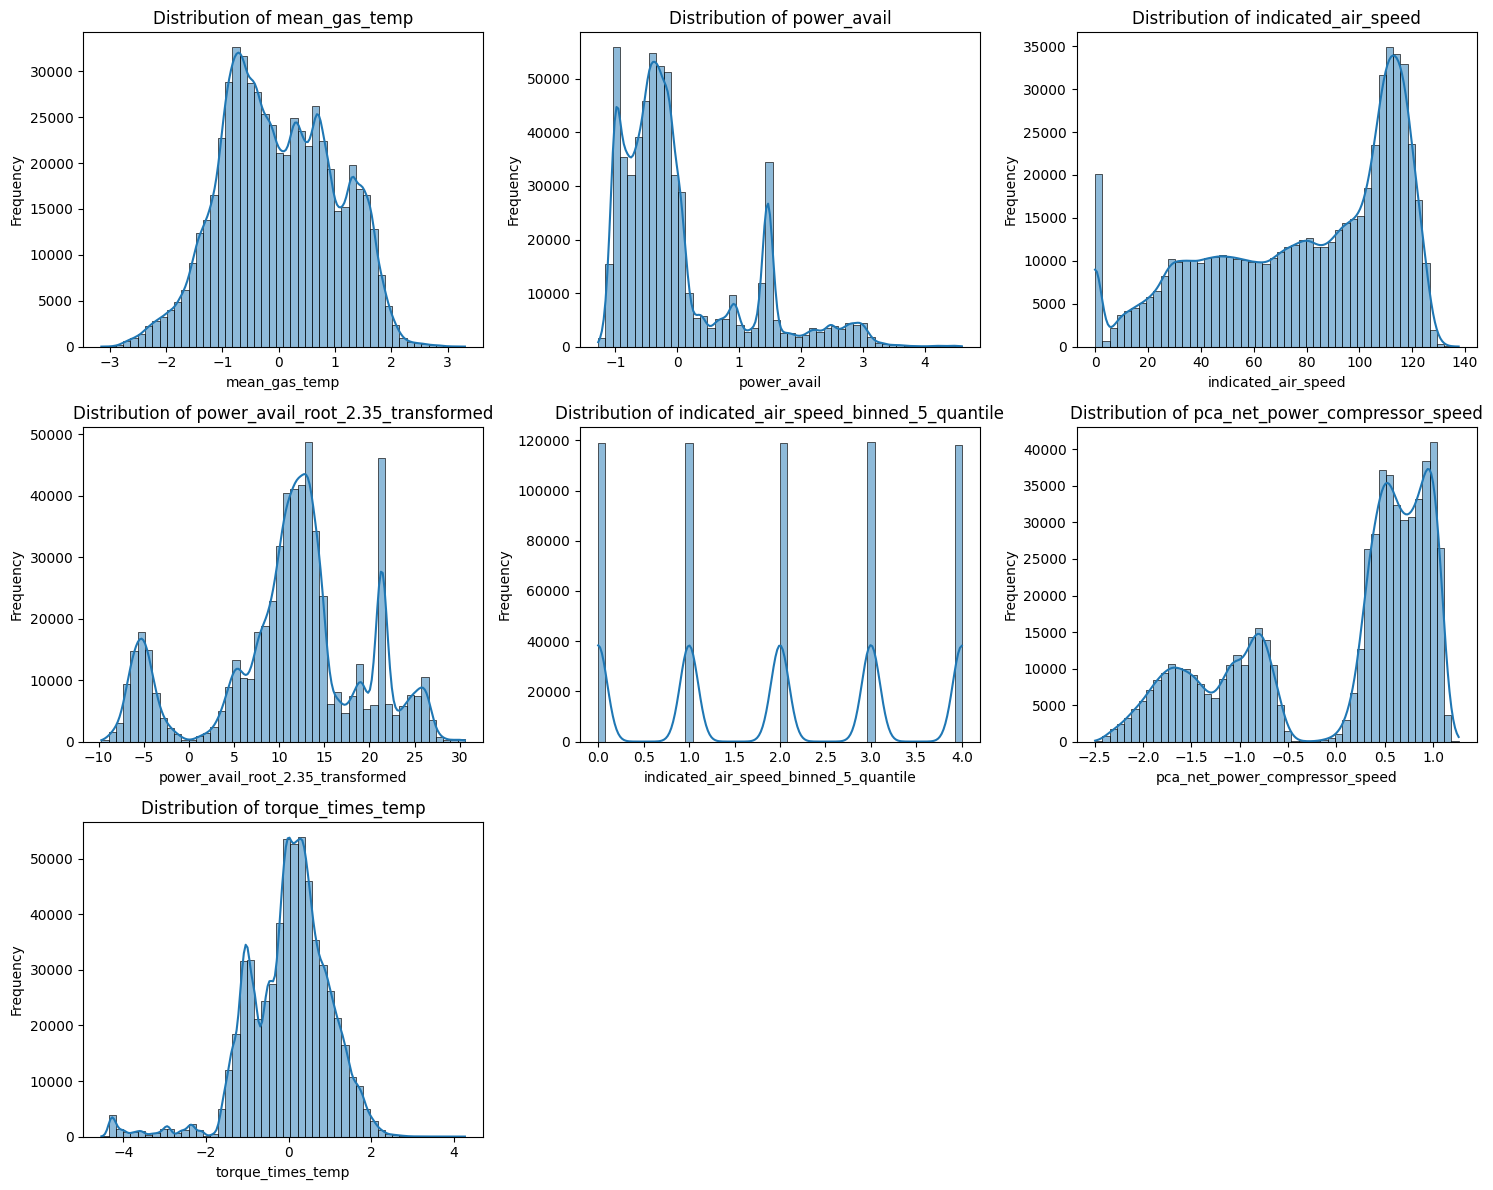

In [ ]:
# prompt: Aggiungi alla fine alla pipeline della cella sopra la trasformazione 'ColumnStandardizer' su  (in maniera tale che i valori di ognuna delle nuove feature vadano da -1 a 1): 'mean_gas_temp', 'power_avail', 'indicated_air_speed',
#        'power_avail_root_2.35_transformed',
#        'indicated_air_speed_binned_5_quantile',
#        'pca_net_power_compressor_speed', 'torque_times_temp'. Mostra poi la distribuzione dei dati

# Add ColumnStandardizer to the pipeline
pipeline_with_all_features_and_standardizer = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data[:-1])),
    ('custom_root_power_avail', CustomRootTransformer(root_transformations={'power_avail': 2.35})),
    ('binned_air_speed', BinnedQualitativeTransformer(binning_config={'indicated_air_speed': (5, 'quantile')})),
    ('pca_speed_power', PCATransformer(columns_to_pca=['net_power', 'compressor_speed'], n_components=1)),
    ('torque_temp_feature', TorqueTempFeature()),
    ('standardize_selected', ColumnStandardizer(columns_to_standardize=[
        'mean_gas_temp',
        'power_avail',
        'pca_net_power_compressor_speed',
        'torque_times_temp'
    ]))
])

# Apply the updated pipeline to data_train_x
data_train_final_processed_x = pipeline_with_all_features_and_standardizer.fit_transform(data_train_x)

print("\nPipeline with all transformations and ColumnStandardizer applied to data_train_x:")
print(data_train_final_processed_x.head())
print(data_train_final_processed_x.columns) # Check the columns

# Display the distribution of the final processed data
n_cols = 3
n_rows = (len(data_train_final_processed_x.columns) + n_cols - 1) // n_cols
plt.figure(figsize=(15, n_rows * 4))
for i, col in enumerate(data_train_final_processed_x.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data_train_final_processed_x[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig("grafico_final_processed.png")
plt.show()

In [ ]:
# prompt: aggiungi alla pipeline in cui viene applicata feature_renamer: a) la trasfromazione CustomRootTransformer su power_avail b) la trasformazione  create_binned_qualitative_variable suindicated_air_speed c) la trasformazione PCATransformer su 'net_power' e 'compressor_speed' d) la trasformazione TorqueTempFeature su 'torque_meas' e 'outside_air_temp'. Infine applica 'DataScaler' su tutte compresa torque_times_temp

# Add DataScaler at the end of the pipeline
pipeline_complete_with_scaler = Pipeline([
    ('rename_features', FeatureRenamer(column_names=new_names_for_train_data)),
    # Add the new transformations after renaming
    ('custom_root_power_avail', CustomRootTransformer(root_transformations=root_transformation_config)),
    ('binned_indicated_air_speed', BinnedQualitativeTransformer(binning_config=binning_config_indicated_air_speed)),
    ('pca_net_power_compressor_speed', PCATransformer(**pca_config)),
    ('torque_temp_feature', TorqueTempFeature()),
    # Add DataScaler to scale all numerical columns including the new one
    ('scale_data', DataScaler()),
])

# Example of applying the pipeline (assuming data_train is available from the previous code)
# Note: The FeatureRenamer expects a DataFrame. If data_train is a tuple, it handles it.
try:
    # Fit the pipeline on the training data
    pipeline_complete_with_scaler.fit(data_train)

    # Transform the training data using the fitted pipeline
    data_train_processed_scaled = pipeline_complete_with_scaler.transform(data_train)

    # ---------------------- Output ----------------------
    print("\nDataFrame processed and scaled using complete Pipeline:")
    print(data_train_processed_scaled.head())
    print("\nColumns after complete pipeline with scaling:", data_train_processed_scaled.columns.tolist())
    print("\nDescription of processed and scaled data:")
    print(data_train_processed_scaled.describe())

except Exception as e:
    print(f"An error occurred while applying the complete pipeline with scaling: {e}")
    print("Please ensure 'data_train' is a pandas DataFrame or a tuple containing DataFrames.")


An error occurred while applying the complete pipeline with scaling: Column count mismatch after dropping 'id'.
Please ensure 'data_train' is a pandas DataFrame or a tuple containing DataFrames.
